In [ ]:
# default_exp utils
pass

# Utilities

> This module defines several utility functions. Mainly binning-related.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

import numpy as np
import scipy.stats
from typing import Callable
import warnings
import logging

In [ ]:
# export

def get_bin_indices(y_probs:np.array, bins='fd', lower:float=None, upper:float=None, return_edges:bool=False, n_bins:int=10):
    """Compute a function across.

    Parameters:
    y_probs -- Predicted class probabilities
    bins -- Number of bins (see `np.histogram_bin_edges` for options)
    return_edges -- Return the edges used for the binning
    lower -- Lower bound of confidence values
    upper -- Upper bound of confidence values
    return_edges -- Set to return identified edges

    Returns:
    bin_indices (np.array) -- Array that maps instances to bins
    edges (np.array) -- Bin edges if return_edges is True

    """

    # check inputs
    assert len(y_probs.shape) == 1 and y_probs.dtype in [np.float, np.float32], 'Predicted class probabilties should be an array of floats'
    assert all(y_probs >= 0) and all(y_probs <= 1), 'Predicted class probabilities should lie between 0 and 1'

    # compute the bins
    if lower is None:
        lower = y_probs.min()
    if upper is None:
        upper = y_probs.max()

    if bins == "count":
        
        assert n_bins <= len(y_probs), "Too little observations."
        
        obs_per_bin = len(y_probs) // n_bins
         
        edges = np.empty((n_bins+1), dtype=float)
        edges[0] = 0.0
        edges[-1] = 1.0
        edges[1:n_bins] = np.sort(y_probs)[np.arange(1, n_bins)*obs_per_bin]
    else:
        edges = np.histogram_bin_edges(y_probs, bins=bins, range=(lower, upper))

    if not isinstance(bins, int):
        bins = len(edges) - 1

    # bin the confidence levels
    bin_indices = np.digitize(y_probs, edges, right=True)

    if return_edges:
        return bin_indices, edges

    return bin_indices


def binning(y_probs:np.array, y_preds:np.array, y_true:np.array, bin_indices:np.array, bin_func:Callable):
    """Compute a function across bins of confidence levels.

    Parameters:
    y_probs -- Predicted class probabilities
    y_preds -- Predicted class labels
    y_true -- True class labels
    bin_indices -- Array that maps instances to bins (as obtained by `utils.get_bin_indices`)
    bin_func -- Function to compute for each bin

    Returns:
    result (float) -- Result of the computation across bins

    """

    # check inputs
    assert len(y_probs.shape) == 1 and y_probs.dtype in [np.float, np.float32], 'Predicted class probabilties should be an array of floats'
    assert all(y_probs >= 0) and all(y_probs <= 1), 'Predicted class probabilities should lie between 0 and 1'
    assert len(y_preds.shape) == 1, 'Predicted class labels should be a 1-D array'
    assert len(y_true.shape) == 1, 'True class labels should be a 1-D array'

    result = 0.
    for i in np.unique(bin_indices):
        y_probs_bin, y_preds_bin, y_true_bin = y_probs[bin_indices==i], y_preds[bin_indices==i], y_true[bin_indices==i]

        # update current estimate
        result += (len(y_probs_bin) / y_probs.shape[0]) * bin_func(y_probs_bin, y_preds_bin, y_true_bin)
    return result

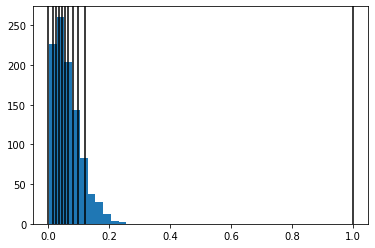

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt

data = beta.rvs(2,30, size=1000)
indices, edges = get_bin_indices(y_probs=data, bins="count", lower=0, upper=1, n_bins=10, return_edges=True)
plt.hist(data, bins=10)
for edge in edges:
    plt.axvline(edge, color="black")